In [4]:
import sys, os, glob, time
import h5py
import corner
from copy import copy as copy
from collections import defaultdict
import numpy as np
import scipy as sp
import numpy.random as rnd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial, gamma, genlaguerre
from multiprocessing import Pool, Process, Manager
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import cm, lines, patches, ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#plt.rcParams.update({"text.usetex": True})

from parameters import get_parameters, setup_dom

from modules.density_extraction import density_extraction, calc_ensemble_dists
from diffraction_simulation import diffraction_calculation

from modules.NO2 import *

In [5]:
params = get_parameters()
use_2dof = False
use_mol_ensemble = True

#####  Setup ensemble/density generators and log prior  #####
if use_mol_ensemble:
    input_ensemble_generator = molecule_ensemble_generator
else:
    input_ensemble_generator = single_molecule_generator

input_density_generator_gauss = molecule_ensemble_generator
input_density_generator_delta = single_molecule_generator
    
if "density_model" in params:
    if params["density_model"] == "PDF":
        input_density_generator = molecule_ensemble_generator
        if use_2dof or params["experiment"] == "2dof":
            input_log_prior = log_prior_2dof_gauss
        elif params["experiment"] == "3dof":
            input_log_prior = log_prior_3dof_gauss
        else:
            raise ValueError("Cannot handle experiment {}".format(
                    params["experiment"]))

    elif params["density_model"] == "delta":
        input_density_generator = single_molecule_generator
        if use_2dof or params["experiment"] == "2dof":
            input_log_prior = log_prior_2dof_delta
        elif params["experiment"] == "3dof":
            input_log_prior = log_prior_3dof_delta
        else:
            raise ValueError("Cannot handle experiment {}".format(
                    params["experiment"]))

    else:
        raise ValueError("Cannot handle density model {}".format(
                params["density_model"]))
else:
    raise ValueError("Must provide default density generator")

INFO: Making output folder
INFO: Setup Multiprocessing
INFO: Importing ground state geometry
	 O: 0.000000 0.526705 1.243013
	 N: 0.000000 0.000000 0.000000
	 O: 0.000000 0.409659 -0.966789
INFO: Setting up moment of inertia calculation
INFO: Rotating initial state molecular frame
INFO: Getting data
INFO: Getting scattering amplitudes
INFO: Simulate data

########################################
#####  Molecular Ensemble Results  #####
########################################

#####  Mean molecule thetas  #####
[1.35 1.05 2.34]

#####  STD molecule thetas  #####
[0.03 0.02 0.01]

#####  Mean molecule cartesian  #####
[[ 0.52669819  0.          1.24299777]
 [ 0.          0.          0.        ]
 [ 0.40965415  0.         -0.96677604]]

#####  STD molecule cartesian  #####
[[0.01325286 0.         0.0277475 ]
 [0.         0.         0.        ]
 [0.00917936 0.         0.01852839]]

#####  Mean d3  #####
2.2129129603522664

#####  STD d3  #####
0.033758951266729426




/cds/home/k/khegazy/TeDDE/NO2/plots/analysis/modules/density_extraction.py:779: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.data_params["dom"] is None or "ata" in self.data_params["dom"]:


FIN SHAPES (9, 473) (9, 473)
INFO: Pruning data
INFO: Calculating I0
INFO: Initial thetas used to fit I0
	 [1.35 0.03 1.05 0.02 2.34 0.01]

########################################
#####  Molecular Ensemble Results  #####
########################################

#####  Mean molecule thetas  #####
[1.35 1.05 2.34]

#####  STD molecule thetas  #####
[0.03 0.02 0.01]

#####  Mean molecule cartesian  #####
[[ 0.52669819  0.          1.24299777]
 [ 0.          0.          0.        ]
 [ 0.40965415  0.         -0.96677604]]

#####  STD molecule cartesian  #####
[[0.01325286 0.         0.0277475 ]
 [0.         0.         0.        ]
 [0.00917936 0.         0.01852839]]

#####  Mean d3  #####
2.2129129603522664

#####  STD d3  #####
0.033758951266729426


###############################################################
#####  Checking Scale of Spherical Bessel Function Error  #####
###############################################################
L = 2 	 Largest std = 2.3592239273284576e-14 at i

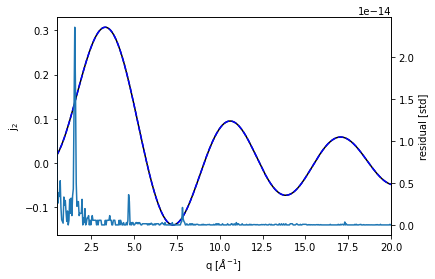

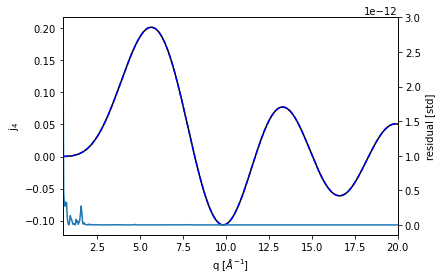

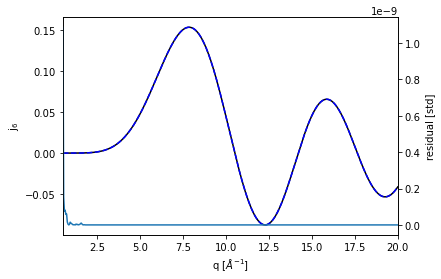

In [8]:
dp = copy(params)
dp["molecule"] = "NO2_symbreak"
dp["experiment"] = "3dof"
dp["init_geo_xyz"] = "XYZ/NO2_symbreak.xyz"
dp["fit_range"] = [0.5, 20]
dp["density_model"] = "PDF"
dp["simulate_error"] = ("constant_sigma", 0.1)#("StoN", (100, [0.5,4]))
dp = setup_dom(dp)

# Setup the LMK contributions used
FB = []
lmk = np.arange(4)*2
for l in lmk:
    if l == 0 or l%2 != 0:
        continue
    for k in lmk:
        if k <= l:# and k > 0:
            FB.append(np.array([l,0,k]))
FB = np.array(FB).astype(int)
dp["fit_bases"] = FB
del dp["save_sim_data"]
exx = density_extraction(dp,
    get_molecule_init_geo,
    get_scattering_amplitudes,
    log_prior=input_log_prior,
    density_generator=input_density_generator,
    ensemble_generator=input_ensemble_generator,
    get_ADMs=get_ADMs, make_plot_dirs=False)

C_analysis = exx.data_coeffs
C_var_analysis = exx.data_coeffs_var
q_c = exx.dom
print(exx.ADMs)
LMK, ADMs, norms, adm_times = exx.get_ADMs(exx.data_params["ADM_params"], exx.data_LMK)

In [10]:
eval_times = [39.05, 39.25, 39.68, 39.85, 40.05]
eval_times = np.linspace(37.742, 40.845, 8)
#eval_times = eval_times[1:]

dfrctn = []
for tm in eval_times:
    fName = os.path.join("output", "NO2_symbreak_sim_diffraction-analytic_Qmax-20_time-{0:.6g}.h5".format(float(tm)))
    if os.path.exists(fName):
        with h5py.File(fName, "r") as h5:
            dfrctn.append(h5["mod_diffraction"][:])
            q = h5["q"][:]
    else:
        print("Can't find diffraction "+fName)
    
dfrctn = np.array(dfrctn)
sz = q.shape[-1]//2
q_2d = q[sz:,sz:]
q = q_2d[0,:]
dfrctn = dfrctn[:,sz:,sz:]
dfrctn /= np.max([np.abs(np.amin(dfrctn)), np.amax(dfrctn)])

<ipython-input-12-986b9823680f>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_df[i].pcolormesh(X, Y, dfrctn[i], cmap='seismic', vmin=-1, vmax=1)
<ipython-input-12-986b9823680f>:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_b[i].pcolormesh(X, Y, B[i]*scales[i], cmap='seismic', vmax=1, vmin=-1)


(461, 100) (461, 100) (461, 100) (100,) (300,) (9, 100) (9, 461)
(461, 100) (461, 100) (461, 100) (100,) (300,) (9, 100) (9, 461)
(461, 100) (461, 100) (461, 100) (100,) (300,) (9, 100) (9, 461)


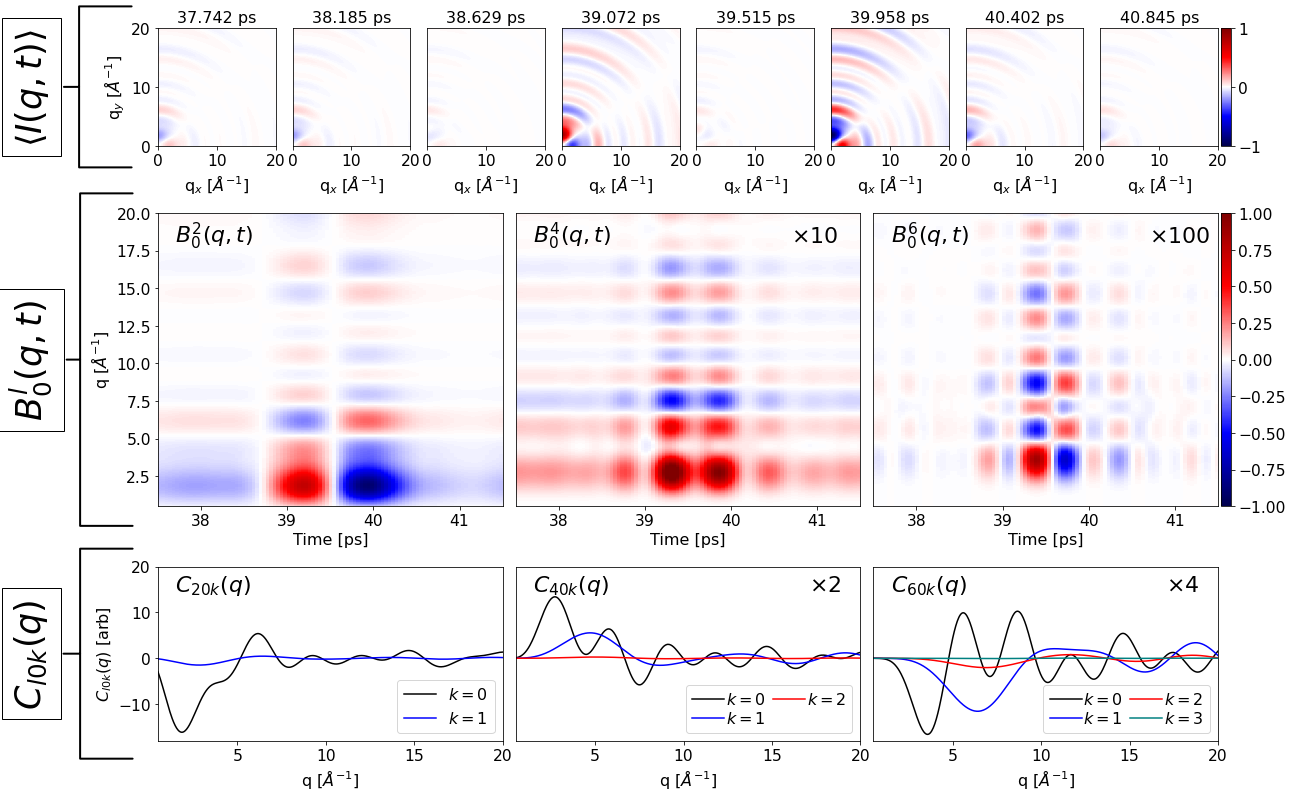

In [12]:
lp, rp, bp, tp = 0.13, 0.052, 0.07, 0.03
txt_size = 22
label_size = 16#15.5
tick_size = 15.5#15
title_size = 35

fig_w, fig_h = 18, 11
fig = plt.figure(figsize=(fig_w,fig_h))
colors = ['k', 'b', 'r', 'teal', 'pink', 'g']

#####  Diffraction Images  #####
hspace_df = 0.013
hdim_df = (1-(lp+rp)-(len(eval_times)-1)*hspace_df)/len(eval_times)
vdim_df = hdim_df*fig_w/fig_h
ax_df = []
for i in range(len(eval_times)):
    ax_df.append(fig.add_axes((lp+i*(hdim_df+hspace_df), 1-(tp+vdim_df), hdim_df, vdim_df)))

X,Y = np.meshgrid(q, q)
for i,tm in enumerate(eval_times):
    im = ax_df[i].pcolormesh(X, Y, dfrctn[i], cmap='seismic', vmin=-1, vmax=1)
    ax_df[i].set_title("{0:.5g} ps".format(tm), fontsize=label_size)
    ax_df[i].set_xlabel("q$_x$ $[\AA^{-1}]$", fontsize=label_size)
    ax_df[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_df[i].yaxis.set_visible(False)
    else:
        ax_df[i].set_ylabel("q$_y$ $[\AA^{-1}]$", fontsize=label_size)
        ax_df[i].tick_params(axis='y', labelsize=tick_size)
    #print(dfrctn)

cbar_df = fig.add_axes((lp+len(eval_times)*(hdim_df+hspace_df)-hspace_df+0.0025, 1-(tp+vdim_df), 0.0075, vdim_df))
fig.colorbar(im, cax=cbar_df)
cbar_df.tick_params(labelsize=tick_size)

ax_df[0].annotate(r"$\langle I(q,t) \rangle$", xy=(-0.6525, 0.5), xytext=(-1.07, 0.5), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=2.3, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180")) 

#####  B coefficients  #####
L = np.unique(LMK[:,0])
hspace_bc, vspace_b = 0.01, 0.085
hdim_bc = (1-(lp+rp)-(len(L)-1)*hspace_bc)/len(L)
vdim_b = 0.37
ax_b = []
for i in range(len(L)):
    ax_b.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), 1-(tp+vdim_b+vdim_df+vspace_b), hdim_bc, vdim_b)))

B = []
X, Y = np.meshgrid(adm_times, q_c)
for i, l in enumerate(L):
    B_ = np.zeros((len(q_c), len(adm_times)))
    for k in np.arange(l+1):
        if k%2 == 0:
            ind = (LMK[:,0]==l)*(LMK[:,2]==k)
            B_ += C_analysis[ind].transpose()*ADMs[ind]
    B.append(copy(B_))
B = np.array(B)
B /= 1.1*np.amax(np.abs(B))
scales = [1, 10, 100]

for i, l in enumerate(L):
    print(X.shape, Y.shape, B[i].shape, adm_times.shape, q.shape,ADMs.shape, C_analysis.shape)
    im = ax_b[i].pcolormesh(X, Y, B[i]*scales[i], cmap='seismic', vmax=1, vmin=-1)
    ax_b[i].text(0.05, 0.9, r"$B_0^{}(q,t)$".format(l),
            transform=ax_b[i].transAxes, fontsize=txt_size)
    ax_b[i].set_xlabel("Time [ps]", fontsize=label_size)
    ax_b[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_b[i].yaxis.set_visible(False)
        ax_b[i].text(0.8, 0.9, r"$\times{}$".format(scales[i]),
                transform=ax_b[i].transAxes, fontsize=txt_size)
    else:
        ax_b[i].set_ylabel("q $[\AA^{-1}]$", fontsize=label_size)
        ax_b[i].tick_params(axis='y', labelsize=tick_size)

cbar_b = fig.add_axes((lp+len(L)*(hdim_bc+hspace_bc)-hspace_bc+0.0025, 1-(tp+vdim_b+vdim_df+vspace_b), 0.0075, vdim_b))
fig.colorbar(im, cax=cbar_b)
cbar_b.tick_params(labelsize=tick_size)

ax_b[0].annotate(r"$B_0^l(q,t)$", xy=(-0.22, 0.5), xytext=(-0.37, 0.5), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=4.75, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))

#####  C Coefficients  #####
vspace_c = 0.015
vdim_c = 0.22
ax_c = []
for i in range(len(L)):
    ax_c.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), bp, hdim_bc, vdim_c)))

scales = [1, 2, 4]
for i,l in enumerate(L):
    inds_c = LMK[:,0] == l
    for j, (lmk,C) in enumerate(zip(LMK[inds_c], C_analysis[inds_c])):
        ax_c[i].plot(q_c, C*scales[i], color=colors[j], label="$k={}$".format(j))
    ax_c[i].text(0.05, 0.86, r"$C_{"+str(l)+"0k}(q)$",
          transform=ax_c[i].transAxes, fontsize=txt_size)
    ax_c[i].set_xlim(q_c[0], q_c[-1])
    ax_c[i].set_ylim(-18, 20)
    ax_c[i].set_xlabel("q $[\AA^{-1}]$", fontsize=label_size)
    ax_c[i].tick_params(axis='x', labelsize=tick_size)
    ax_c[i].set_ylabel("$C_{l0k}(q)$ [arb]", fontsize=label_size)
    ax_c[i].legend(loc="lower right")
    if i != 0:
        ax_c[i].yaxis.set_visible(False)
        ax_c[i].text(0.85, 0.86, r"$\times{}$".format(scales[i]),
                transform=ax_c[i].transAxes, fontsize=txt_size)
        ax_c[i].legend(loc="lower right", ncol=2, fontsize=label_size, handletextpad=0.1, labelspacing=0.2, columnspacing=0.45)
    else:
        ax_c[i].tick_params(axis='y', labelsize=tick_size)
        ax_c[i].legend(loc="lower right", fontsize=label_size)

ax_c[0].annotate(r"$C_{l0k}(q)$", xy=(-0.22, 0.5), xytext=(-0.367, 0.5), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=3.0, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))

fig.savefig("analysisStepss.png")

# Simulation Only

shape check (300, 300) (300, 300) (300, 300)
(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)
(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)
(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)


<ipython-input-21-b056aee71cec>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_df[i].pcolormesh(X, Y, dfrctn[i], cmap='seismic', vmin=-1, vmax=1)
<ipython-input-21-b056aee71cec>:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_b[i].pcolormesh(X, Y, (B[i]*scales[i]).transpose(), cmap='seismic', vmax=1, vmin=-1)


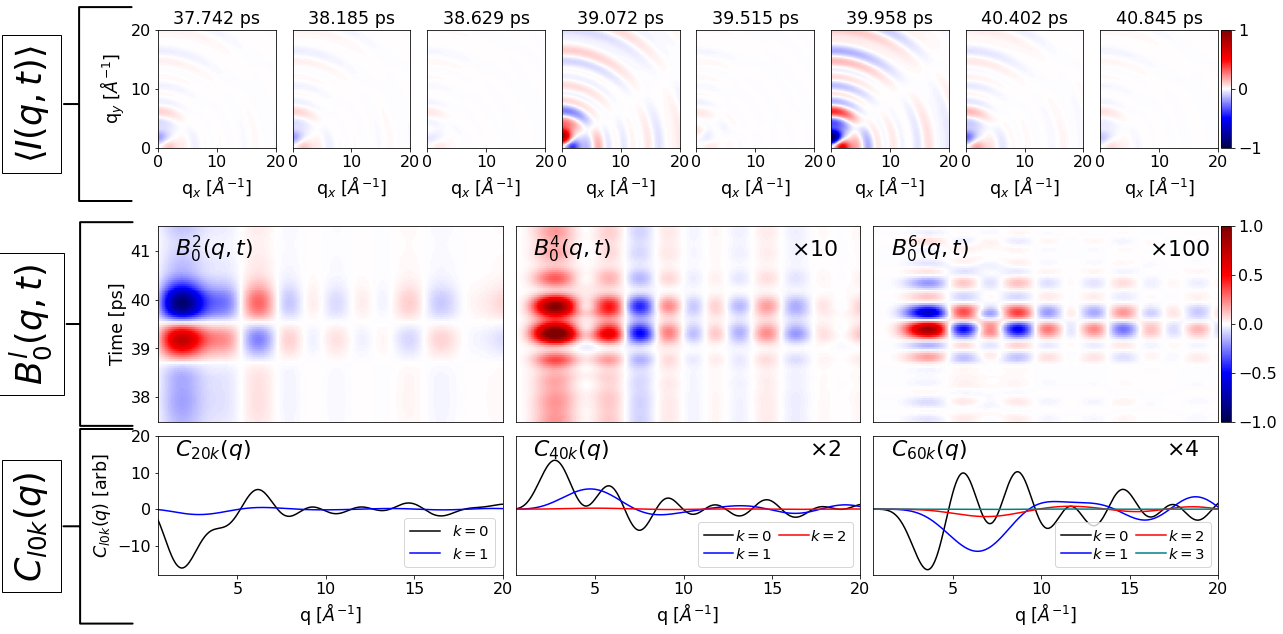

In [21]:
lp, rp, bp, tp = 0.13, 0.052, 0.085, 0.05
txt_size = 22
label_size = 17.5#15.5
tick_size = 16#15
title_size = 35

fig_w, fig_h = 18, 8.75
fig = plt.figure(figsize=(fig_w,fig_h))
colors = ['k', 'b', 'r', 'teal', 'pink', 'g']

#####  Diffraction Images  #####
hspace_df = 0.013
hdim_df = (1-(lp+rp)-(len(eval_times)-1)*hspace_df)/len(eval_times)
vdim_df = hdim_df*fig_w/fig_h
ax_df = []
for i in range(len(eval_times)):
    ax_df.append(fig.add_axes((lp+i*(hdim_df+hspace_df), 1-(tp+vdim_df), hdim_df, vdim_df)))

X,Y = np.meshgrid(q, q)
print("shape check", X.shape, Y.shape, dfrctn[0].shape)
for i,tm in enumerate(eval_times):
    im = ax_df[i].pcolormesh(X, Y, dfrctn[i], cmap='seismic', vmin=-1, vmax=1)
    ax_df[i].set_title("{0:.5g} ps".format(tm), fontsize=label_size)
    ax_df[i].set_xlabel("q$_x$ $[\AA^{-1}]$", fontsize=label_size)
    ax_df[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_df[i].yaxis.set_visible(False)
    else:
        ax_df[i].set_ylabel("q$_y$ $[\AA^{-1}]$", fontsize=label_size)
        ax_df[i].tick_params(axis='y', labelsize=tick_size)
    #print(dfrctn)

cbar_df = fig.add_axes((lp+len(eval_times)*(hdim_df+hspace_df)-hspace_df+0.0025, 1-(tp+vdim_df), 0.0075, vdim_df))
fig.colorbar(im, cax=cbar_df)
cbar_df.tick_params(labelsize=tick_size)

ax_df[0].annotate(r"$\langle I(q,t) \rangle$", xy=(-0.6525, 0.37), xytext=(-1.07, 0.37), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=2.77, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180")) 

#####  B coefficients  #####
L = np.unique(LMK[:,0])
hspace_bc, vspace_b = 0.01, 0.125
hdim_bc = (1-(lp+rp)-(len(L)-1)*hspace_bc)/len(L)
vdim_b = 0.31
ax_b = []
for i in range(len(L)):
    ax_b.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), 1-(tp+vdim_b+vdim_df+vspace_b), hdim_bc, vdim_b)))

B = []
X, Y = np.meshgrid(q_c, adm_times)
for i, l in enumerate(L):
    B_ = np.zeros((len(q_c), len(adm_times)))
    for k in np.arange(l+1):
        if k%2 == 0:
            ind = (LMK[:,0]==l)*(LMK[:,2]==k)
            B_ += C_analysis[ind].transpose()*ADMs[ind]
    B.append(copy(B_))
B = np.array(B)
B /= 1.1*np.amax(np.abs(B))
scales = [1, 10, 100]

for i, l in enumerate(L):
    print(X.shape, Y.shape, B[i].shape, adm_times.shape, q.shape,ADMs.shape, C_analysis.shape)
    im = ax_b[i].pcolormesh(X, Y, (B[i]*scales[i]).transpose(), cmap='seismic', vmax=1, vmin=-1)
    ax_b[i].text(0.05, 0.85, r"$B_0^{}(q,t)$".format(l),
            transform=ax_b[i].transAxes, fontsize=txt_size)
    ax_b[i].xaxis.set_visible(False)
    ax_b[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_b[i].yaxis.set_visible(False)
        ax_b[i].text(0.8, 0.85, r"$\times{}$".format(scales[i]),
                transform=ax_b[i].transAxes, fontsize=txt_size)
    else:
        ax_b[i].set_ylabel("Time [ps]", fontsize=label_size)
        #ax_b[i].set_ylabel("q $[\AA^{-1}]$", fontsize=label_size)
        ax_b[i].tick_params(axis='y', labelsize=tick_size)

cbar_b = fig.add_axes((lp+len(L)*(hdim_bc+hspace_bc)-hspace_bc+0.0025, 1-(tp+vdim_b+vdim_df+vspace_b), 0.0075, vdim_b))
fig.colorbar(im, cax=cbar_b)
cbar_b.tick_params(labelsize=tick_size)

ax_b[0].annotate(r"$B_0^l(q,t)$", xy=(-0.22, 0.5), xytext=(-0.37, 0.5), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=2.91, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))

#####  C Coefficients  #####
vspace_c = 0.015
vdim_c = 0.22
ax_c = []
for i in range(len(L)):
    ax_c.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), bp, hdim_bc, vdim_c)))

scales = [1, 2, 4]
for i,l in enumerate(L):
    inds_c = LMK[:,0] == l
    for j, (lmk,C) in enumerate(zip(LMK[inds_c], C_analysis[inds_c])):
        ax_c[i].plot(q_c, C*scales[i], color=colors[j], label="$k={}$".format(j))
    ax_c[i].text(0.05, 0.86, r"$C_{"+str(l)+"0k}(q)$",
          transform=ax_c[i].transAxes, fontsize=txt_size)
    ax_c[i].set_xlim(q_c[0], q_c[-1])
    ax_c[i].set_ylim(-18, 20)
    ax_c[i].set_xlabel("q $[\AA^{-1}]$", fontsize=label_size)
    ax_c[i].tick_params(axis='x', labelsize=tick_size)
    ax_c[i].set_ylabel("$C_{l0k}(q)$ [arb]", fontsize=label_size)
    ax_c[i].legend(loc="lower right")
    if i != 0:
        ax_c[i].yaxis.set_visible(False)
        ax_c[i].text(0.85, 0.86, r"$\times{}$".format(scales[i]),
                transform=ax_c[i].transAxes, fontsize=txt_size)
        ax_c[i].legend(loc="lower right", ncol=2, fontsize=label_size*0.85, handletextpad=0.1, labelspacing=0.2, columnspacing=0.45)
    else:
        ax_c[i].tick_params(axis='y', labelsize=tick_size)
        ax_c[i].legend(loc="lower right", fontsize=label_size*0.85)

ax_c[0].annotate(r"$C_{l0k}(q)$", xy=(-0.22, 0.35), xytext=(-0.367, 0.35), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=2.78, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))

fig.savefig("analysisSteps_NO2_only.png")

# Simulation and N2O Data Comparison

In [ ]:
from parameters_N2O_data import get_parameters as get_data_params

## Importing N2O Data

In [15]:
data_params = get_data_params()
data_params["init_geo_xyz"] = "/cds/home/k/khegazy/analysis/2015/timeBasis_N2O_NO2/simulation/XYZfiles/N2O.xyz"
data_params["scat_amps_dir"] = "/cds/home/k/khegazy/simulation/scatteringAmplitudes/3.7MeV"
data_cut = 55
do_ensemble = True
do_2dof = False

data_params_orig = copy(data_params)
inp_data, inp_var = [], []
with h5py.File("/cds/group/ued/scratch/N2O/physics_time_basis/legendre_coeffs.h5", "r") as h5:
    q_data = h5["q"][:]
    LMK_data = h5["LMK"][:]
    b_data = h5["coefficients"][:]

with h5py.File(data_params['data_fileName'], "r") as h5:
    t0 = h5["t0"][...]
    time = np.arange(b_data.shape[-1])*0.1 + t0


#print(inp_data.shape, inp_var.shape, h5["fit_coeffs_dataLMKindex-1"][:].shape)

#data_params["fit_range"] = [1.95, q[-1]]

if do_ensemble:
    input_ensemble_generator = molecule_ensemble_generator
else:
    input_ensemble_generator = single_molecule_generator

if "density_model" in data_params:
    if data_params["density_model"] == "PDF":
        input_density_generator = molecule_ensemble_generator
        if do_2dof or data_params["experiment"] == "2dof":
            input_log_prior = log_prior_2dof_gauss
        elif data_params["experiment"] == "3dof":
            input_log_prior = log_prior_3dof_gauss
        else:
            raise ValueError("Cannot handle experiment {}".format(
                    data_params["experiment"]))

    elif data_params["density_model"] == "delta":
        input_density_generator = single_molecule_generator
        if do_2dof or data_params["experiment"] == "2dof":
            input_log_prior = log_prior_2dof_delta
        elif data_params["experiment"] == "3dof":
            input_log_prior = log_prior_3dof_delta
        else:
            raise ValueError("Cannot handle experiment {}".format(
                    data_params["experiment"]))

    else:
        raise ValueError("Cannot handle density model {}".format(
                data_params["density_model"]))
else:
    raise ValueError("Must provide default density generator")



extraction = density_extraction(data_params,
      get_molecule_init_geo,
      get_scattering_amplitudes,
      log_prior=None,#input_log_prior,
      density_generator=input_density_generator,
      ensemble_generator=input_ensemble_generator,
      get_ADMs=None, make_plot_dirs=False)

with h5py.File("/cds/group/ued/scratch/N2O/mergeScans/images_aligned.h5", "r") as f:
    data_q = f['q'][:]
    data_imgs_ = f['images_align'][:]
    data_centers = f['centers_align'][:]
data_imgs = data_imgs_ - np.nanmean(np.nanmean(data_imgs_[4:-4], axis=0, keepdims=True), axis=1, keepdims=True)

print(extraction.scat_amps.keys())
atm_scat = 2*extraction.scat_amps_interp['N'](q_data)**2 + extraction.scat_amps_interp['O'](q_data)**2

INFO: Making output folder
INFO: Setup Multiprocessing
INFO: Importing ground state geometry
	 N: 0.000000 0.000000 0.000000
	 N: 0.000000 0.000000 1.125700
	 O: 0.000000 0.000000 -1.186300
INFO: Setting up moment of inertia calculation
INFO: Rotating initial state molecular frame
INFO: Getting data
looking at file:  /cds/group/ued/scratch/N2O/UED_fit_results_Temp-30.0-150.0-121_Ints-1.0-10.0-91_filteredOffset.h5
INFO: Using dom from data
INFO: Getting scattering amplitudes
INFO: Pruning data
INFO: Calculating I0
INFO: Initial thetas used to fit I0
	 [1.128      0.05       1.184      0.05       3.14159265 0.05      ]

########################################
#####  Molecular Ensemble Results  #####
########################################

#####  Mean molecule thetas  #####
[1.128      1.184      3.14159265]

#####  STD molecule thetas  #####
[0.05 0.05 0.05]

#####  Mean molecule cartesian  #####
[[ 6.89994215e-17  0.00000000e+00  1.12764756e+00]
 [ 0.00000000e+00  0.00000000e+00  0.0

(40, 14, 1024, 1024) (40, 14, 2)
7.921982719145268
(100, 100) (100, 100) (100, 100)
608.9603961608871 -415.31705542159034


<ipython-input-18-9e271586df0f>:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(qx, qy, q_img, cmap='seismic', vmin=-500, vmax=500)


(100, 100) (100, 100) (100, 100)
2386.9147288644194 -544.6580799392094
[[ 0.  0.  0.]
 [ 2.  0.  0.]
 [ 4.  0.  0.]
 [ 6.  0.  0.]
 [ 8.  0.  0.]
 [10.  0.  0.]] 316.30909456539456


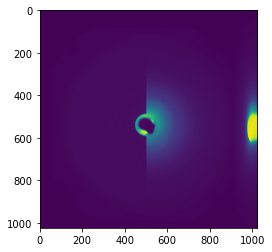

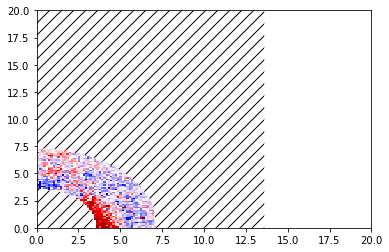

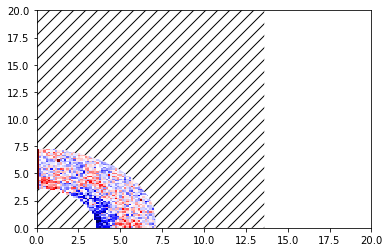

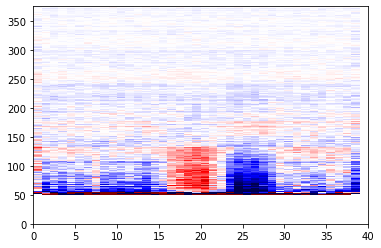

In [18]:
print(data_imgs.shape, data_centers.shape)
#for i in data_imgs[22,3,500,:]:
#    print(i)
plt.imshow(np.sum(data_imgs_[22,:,:,:], axis=0))
print(np.sum(data_imgs[22,6,500,300], axis=0))

x,y = np.meshgrid(np.arange(400), np.arange(400))
r = np.sqrt(x**2 + y**2)
q_scl = (data_q[-1] - data_q[0])/len(data_q)
q_data_plot = r*q_scl
qx = x*(data_q[-1] - data_q[0])/len(data_q)
qy = y*(data_q[-1] - data_q[0])/len(data_q)
atm_scat_data = 2*extraction.scat_amps_interp['N'](q_data_plot)**2 + extraction.scat_amps_interp['O'](q_data_plot)**2
x = np.reshape(x, (-1)).astype(int)
y = np.reshape(y, (-1)).astype(int)

data_tm_inds = [19, 24]
data_df = []
for tm in data_tm_inds:
    q_img = np.zeros((400, 400))
    for im in range(data_imgs.shape[1]):
        q_img[y,x] += data_imgs[tm, im, y+data_centers[tm, im, 0].astype(int), x+data_centers[tm, im, 1].astype(int)]
        q_img[y,x] += data_imgs[tm, im, data_centers[tm, im, 0].astype(int)-y, data_centers[tm, im, 1].astype(int)-x]
    
    rb = 4
    q_img = np.mean(np.reshape(q_img, (q_img.shape[0], -1, 4)), -1)
    q_img = np.mean(np.reshape(q_img, (-1, 4, q_img.shape[-1])), 1)
    qx,qy = np.meshgrid(np.arange(q_img.shape[0]), np.arange(q_img.shape[0]))
    qx = qx*rb*q_scl
    qy = qy*rb*q_scl
    qq = np.sqrt(qx**2 + qy**2)
    q_img[qq<3.5] = 0
    q_img[qq>7.25] = 0
    data_df.append(copy(q_img))
    qq_ = copy(qq)
    qq_[qq>7.25] = 0
    qh_cut = np.argmax(qq_, axis=0)+1
    qh_cut[np.argmax(qq_[0]):] = 0
    qq_ = copy(qq)
    qq_[qq>3.5] = 0
    ql_cut = np.argmax(qq_, axis=0)+1
    ql_cut[np.argmax(qq_[0]):] = 0
    print(qx.shape, qy.shape, q_img.shape)
    fig, ax = plt.subplots()
    ax.pcolormesh(qx, qy, q_img, cmap='seismic', vmin=-500, vmax=500)
    ax.fill_between(qx[0], [20,]*len(qh_cut), qh_cut*q_scl*rb, hatch='//', facecolor='w')
    ax.fill_between(qx[0], ql_cut*q_scl*rb, [0,]*len(qh_cut), hatch='//', facecolor='w')
    ax.set_ylim([0, q_c[-1]])
    ax.set_xlim([0, q_c[-1]])
    
    print(np.amax(q_img), np.amin(q_img))
data_df = ((qx, qy), data_df)

fig, ax = plt.subplots()
ax.pcolormesh(b_data[1,:,:], vmax=45, vmin=-45, cmap='seismic')
print(LMK_data, t0)
    

## Plotting (Run twice)

(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)
(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)
(100, 461) (100, 461) (461, 100) (100,) (300,) (9, 100) (9, 461)


<ipython-input-23-dd447ccf3c8d>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax_b[i].pcolormesh(X, Y, (B[i]*scales[i]).transpose(), cmap='seismic', vmax=1, vmin=-1)
<ipython-input-23-dd447ccf3c8d>:68: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_b_data.pcolormesh(X, Y,
<ipython-input-23-dd447ccf3c8d>:152: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners 

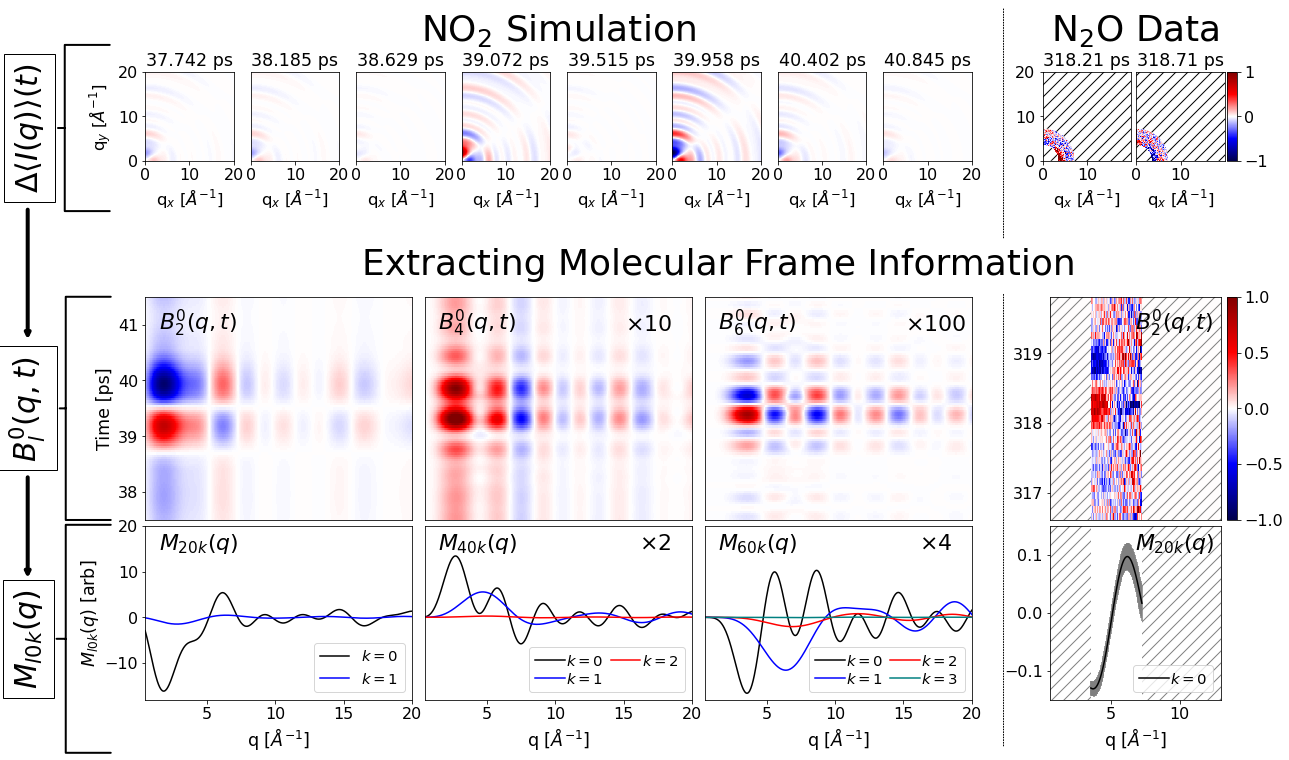

In [23]:
#####  RUN ME TWICE  #####
lp, rp, bp, tp = 0.115, 0.055, 0.085, 0.085
txt_size = 22
label_size = 17.5#15.5
tick_size = 16#15
title_size = 30
data_sim_sep = 0.06
data_q_rng = 13#0.725
data_scale = (data_q_rng-0.5)/19.5

fig_w, fig_h = 18, 10.5
fig = plt.figure(figsize=(fig_w, fig_h))
colors = ['k', 'b', 'r', 'teal', 'pink', 'g']

hspace_df = 0.013
#hdim_df = (1-(lp+rp+data_sim_sep)-(len(eval_times)-1)*hspace_df)/len(eval_times)
hdim_df = (hdim_bc*len(L) + (len(L)-1)*hspace_bc - (len(eval_times)-1)*hspace_df)/len(eval_times)
vdim_df = hdim_df*fig_w/fig_h

#####  B coefficients  #####
L = np.unique(LMK[:,0])
hspace_bc, vspace_b = 0.01, 0.18
hdim_bc = (1-(lp+rp+data_sim_sep)-(len(L)-1)*hspace_bc)/(len(L) + data_scale)
vdim_b = 0.295
ax_b = []
for i in range(len(L)+1):
    if i < len(L):
        ax_b.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), 1-(tp+vdim_b+vdim_df+vspace_b), hdim_bc, vdim_b)))
    else:
        #ax_b_data = fig.add_axes((lp+i*(hdim_bc+hspace_bc)+data_sim_sep, 1-(tp+vdim_b+vdim_df+vspace_b), 0.5*hdim_bc, vdim_b))
        ax_b_data = fig.add_axes((1-rp-data_scale*hdim_bc, 1-(tp+vdim_b+vdim_df+vspace_b), data_scale*hdim_bc, vdim_b))

B = []
X, Y = np.meshgrid(q_c, adm_times)
for i, l in enumerate(L):
    B_ = np.zeros((len(q_c), len(adm_times)))
    for k in np.arange(l+1):
        if k%2 == 0:
            ind = (LMK[:,0]==l)*(LMK[:,2]==k)
            B_ += C_analysis[ind].transpose()*ADMs[ind]
    B.append(copy(B_))
B = np.array(B)
B /= 1.1*np.amax(np.abs(B))
scales = [1, 10, 100]

for i, l in enumerate(L):
    print(X.shape, Y.shape, B[i].shape, adm_times.shape, q.shape,ADMs.shape, C_analysis.shape)
    im = ax_b[i].pcolormesh(X, Y, (B[i]*scales[i]).transpose(), cmap='seismic', vmax=1, vmin=-1)
    ax_b[i].text(0.05, 0.85, r"$B_{}^0(q,t)$".format(l),
            transform=ax_b[i].transAxes, fontsize=txt_size)
    ax_b[i].xaxis.set_visible(False)
    ax_b[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_b[i].yaxis.set_visible(False)
        ax_b[i].text(0.75, 0.85, r"$\times{}$".format(scales[i]),
                transform=ax_b[i].transAxes, fontsize=txt_size)
    else:
        ax_b[i].set_ylabel("Time [ps]", fontsize=label_size)
        #ax_b[i].set_ylabel("q $[\AA^{-1}]$", fontsize=label_size)
        ax_b[i].tick_params(axis='y', labelsize=tick_size)

#tmp = (b_data[1,:,3:-4]-np.mean(b_data[1,:,3:-4], -1, keepdims=True))/np.expand_dims(atm_scat, -1)
b_data_plot = copy(b_data)
b_data[1,q_data>7.25,:] = 0
b_data[1,q_data<3.5,:] = 0
vrng = 0.0275
X,Y = np.meshgrid(q_data, time[3:-4])
ax_b_data.pcolormesh(X, Y,
        (b_data[1,:,3:-4]-np.mean(b_data[1,:,3:-4], -1, keepdims=True)).transpose()/np.expand_dims(atm_scat, 0),
        vmax=vrng, vmin=-1*vrng, cmap='seismic')
ax_b_data.fill_between([q_c[0], 3.5],[time[3],time[3]], [time[-5],time[-5]], facecolor="none", hatch="//", edgecolor="gray", linewidth=0.0)
ax_b_data.fill_between([7.25, data_q_rng],[time[3],time[3]], [time[-5],time[-5]], facecolor="none", hatch="//", edgecolor="gray", linewidth=0.0)
ax_b_data.set_xlim(q_c[0], data_q_rng)
ax_b_data.xaxis.set_visible(False)
ax_b_data.tick_params(axis='y', labelsize=tick_size)
ax_b_data.text(0.5, 0.85, r"$B_2^0(q,t)$",
            transform=ax_b_data.transAxes, fontsize=txt_size)

#cbar_b = fig.add_axes((lp+(len(L)+1)*(hdim_bc+hspace_bc)-hspace_bc+0.0025, 1-(tp+vdim_b+vdim_df+vspace_b), 0.0075, vdim_b))
cbar_b = fig.add_axes((1-rp+0.005, 1-(tp+vdim_b+vdim_df+vspace_b), 0.0075, vdim_b))
fig.colorbar(im, cax=cbar_b)
cbar_b.tick_params(labelsize=tick_size)

ax_b[0].annotate(r"$B_l^0(q,t)$", xy=(-0.29, 0.5), xytext=(-0.44, 0.5), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=3.72, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))

#####  C Coefficients  #####
vspace_c = 0.015
vdim_c = 0.23
ax_c = []
for i in range(len(L)+1):
    if i < len(L):
        ax_c.append(fig.add_axes((lp+i*(hdim_bc+hspace_bc), bp, hdim_bc, vdim_c)))
    else:
        #ax_c_data = fig.add_axes((lp+i*(hdim_bc+hspace_bc)+data_sim_sep, bp, 0.5*hdim_bc, vdim_c))
        ax_c_data = fig.add_axes((1-rp-data_scale*hdim_bc, bp, data_scale*hdim_bc, vdim_c))

scales = [1, 2, 4]
for i,l in enumerate(L):
    inds_c = LMK[:,0] == l
    for j, (lmk,C) in enumerate(zip(LMK[inds_c], C_analysis[inds_c])):
        ax_c[i].plot(q_c, C*scales[i], color=colors[j], label="$k={}$".format(j))
    ax_c[i].text(0.05, 0.86, r"$M_{"+str(l)+"0k}(q)$",
          transform=ax_c[i].transAxes, fontsize=txt_size)
    ax_c[i].set_xlim(q_c[0], q_c[-1])
    ax_c[i].set_ylim(-18, 20)
    ax_c[i].set_xlabel("q $[\AA^{-1}]$", fontsize=label_size)
    ax_c[i].tick_params(axis='x', labelsize=tick_size)
    ax_c[i].set_ylabel("$M_{l0k}(q)$ [arb]", fontsize=label_size)
    ax_c[i].legend(loc="lower right")
    if i != 0:
        ax_c[i].yaxis.set_visible(False)
        ax_c[i].text(0.8, 0.86, r"$\times{}$".format(scales[i]),
                transform=ax_c[i].transAxes, fontsize=txt_size)
        ax_c[i].legend(loc="lower right", ncol=2, fontsize=label_size*0.85, handletextpad=0.1, labelspacing=0.2, columnspacing=0.45)
    else:
        ax_c[i].tick_params(axis='y', labelsize=tick_size)
        ax_c[i].legend(loc="lower right", fontsize=label_size*0.85)

ax_c_data.errorbar(extraction.dom, extraction.data_coeffs[0,:],
        yerr=np.sqrt(extraction.data_coeffs_var[0,:]),
        fmt='--', color='gray')#marker='+')
ax_c_data.plot(extraction.dom, extraction.data_coeffs[0,:], '-k', zorder=10, label="$k=0$")
ax_c_data.fill_between([q_c[0], 3.5],[-0.15, -0.15], [0.15, 0.15], facecolor="none", hatch="//", edgecolor="gray", linewidth=0.0)
ax_c_data.fill_between([7.25, data_q_rng],[-0.15, -0.15], [0.15, 0.15], facecolor="none", hatch="//", edgecolor="gray", linewidth=0.0)
ax_c_data.set_xlim(q_c[0], data_q_rng)
ax_c_data.set_ylim(-0.15, 0.15)
ax_c_data.set_xlabel("q $[\AA^{-1}]$", fontsize=label_size)
ax_c_data.tick_params(axis='x', labelsize=tick_size)
ax_c_data.tick_params(axis='y', labelsize=tick_size)
ax_c_data.legend(loc="lower right", fontsize=label_size*0.85, handletextpad=0.1, labelspacing=0.2, columnspacing=0.45)
ax_c_data.text(0.5, 0.86, r"$M_{20k}(q)$",
          transform=ax_c_data.transAxes, fontsize=txt_size)

ax_c[0].annotate(r"$M_{l0k}(q)$", xy=(-0.29, 0.35), xytext=(-0.437, 0.35), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=3.8, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180"))


#####  Diffraction Images  #####
ax_df = []
for i in range(len(eval_times)):
    ax_df.append(fig.add_axes((lp+i*(hdim_df+hspace_df), 1-(tp+vdim_df), hdim_df, vdim_df)))

X,Y = np.meshgrid(q, q)
for i,tm in enumerate(eval_times):
    im = ax_df[i].pcolormesh(X, Y, dfrctn[i], cmap='seismic', vmin=-1, vmax=1)
    ax_df[i].set_title("{0:.5g} ps".format(tm), fontsize=label_size)
    ax_df[i].set_xlabel("q$_x$ $[\AA^{-1}]$", fontsize=label_size*0.95)
    ax_df[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_df[i].yaxis.set_visible(False)
    else:
        ax_df[i].set_ylabel("q$_y$ $[\AA^{-1}]$", fontsize=label_size*0.95)
        ax_df[i].tick_params(axis='y', labelsize=tick_size)
    ax_df[i].set_xticks([0, 10, 20])
    #print(dfrctn)

ax_data_df = []
rp_ = 1.1*rp
for i in range(2):
    ax_data_df.append(fig.add_axes((1-rp_-data_scale*hdim_bc+i*(hdim_df+0.3*hspace_df), 1-(tp+vdim_df), hdim_df, vdim_df)))

(X, Y), data_df_ = data_df# = np.meshgrid(q, q)
mm = []
for df in data_df_:
    mm.append(np.amax(df))
    mm.append(np.amin(np.abs(df)))
df_scl = 360#np.amax(mm)
for i,q_img in enumerate(data_df_):  
    im = ax_data_df[i].pcolormesh(X, Y, q_img/df_scl, cmap='seismic', vmin=-1, vmax=1)
    ax_data_df[i].fill_between(X[0], [20,]*len(qh_cut), qh_cut*q_scl*rb, hatch='//', facecolor='w')
    ax_data_df[i].fill_between(X[0], ql_cut*q_scl*rb, [0,]*len(qh_cut), hatch='//', facecolor='w')
    ax_data_df[i].fill_between([7.25, 20], [20, 20], [0, 0], hatch='//', facecolor='w')
    ax_data_df[i].set_ylim([0, q_c[-1]])
    ax_data_df[i].set_xlim([0, q_c[-1]])

    ax_data_df[i].set_title("{0:.5g} ps".format(time[data_tm_inds[i]]), fontsize=label_size)
    ax_data_df[i].set_xlabel("q$_x$ $[\AA^{-1}]$", fontsize=label_size*0.95)
    ax_data_df[i].tick_params(axis='x', labelsize=tick_size)
    if i != 0:
        ax_data_df[i].yaxis.set_visible(False)
    else:
        ax_data_df[i].tick_params(axis='y', labelsize=tick_size)
    ax_data_df[i].set_xticks([0,10])
    
#cbar_df = fig.add_axes((lp+len(eval_times)*(hdim_df+hspace_df)-hspace_df+0.0025, 1-(tp+vdim_df), 0.0075, vdim_df))
cbar_df = fig.add_axes((1-rp+0.005, 1-(tp+vdim_df), 0.0075, vdim_df))
fig.colorbar(im, cax=cbar_df)
cbar_df.tick_params(labelsize=tick_size)

ax_df[0].annotate(r"$\Delta \langle I(q) \rangle (t)$", xy=(-0.885, 0.37), xytext=(-1.3, 0.37), xycoords='axes fraction', 
            fontsize=title_size, ha='center', va='center', rotation=90,
            bbox=dict(boxstyle='square', fc="w"),
            arrowprops=dict(arrowstyle='-[, widthB=2.77, lengthB=1.5', lw=2.0,
                           connectionstyle="angle3,angleA=90,angleB=180")) 


#####  Titles  #####
ax_b_data.annotate('', xy=(-0.27, 1.25), xycoords='axes fraction', xytext=(-0.27, 2.3), rotation=90,
arrowprops=dict(arrowstyle="-", linestyle=":", linewidth=1, color='k'))
ax_b_data.annotate('', xy=(-0.27, -1.025), xycoords='axes fraction', xytext=(-0.27, 1.02), rotation=90,
arrowprops=dict(arrowstyle="-", linestyle=":", linewidth=1, color='k'))
ax_b[0].annotate('', xy=(-0.44, 0.8), xycoords='axes fraction', xytext=(-0.44, 1.4), rotation=90,
arrowprops=dict(arrowstyle="->", lw=4, color='k'))
ax_b[0].annotate('', xy=(-0.44, -0.27), xycoords='axes fraction', xytext=(-0.44, 0.2), rotation=90,
arrowprops=dict(arrowstyle="->", lw=4, color='k'))

ax_b[1].text(0.5, 2.15, r"NO$_2$ Simulation", horizontalalignment='center',
                transform=ax_b[1].transAxes, fontsize=title_size*1.2)
ax_b_data.text(0.5, 2.15, r"N$_2$O Data", horizontalalignment='center',
                transform=ax_b_data.transAxes, fontsize=title_size*1.2)
ax_b[1].text(1.1, 1.1, "Extracting Molecular Frame Information", horizontalalignment='center',
                transform=ax_b[1].transAxes, fontsize=title_size*1.2)

fig.savefig("analysisSteps.png")